# Modeling

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, plot_roc_curve, accuracy_score
from sklearn.metrics import log_loss,f1_score, matthews_corrcoef, classification_report, plot_precision_recall_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

### Load Data

In [2]:
X_train = pd.read_csv('../data/Training_Data_Features.csv')
X_test = pd.read_csv('../data/Testing_Data_Features.csv')
y_train = pd.read_csv('../data/Training_Data_Labels.csv')
y_test = pd.read_csv('../data/Testing_Data_Labels.csv')

In [4]:
#check data type for label
y_train.dtypes

isFraud    int64
dtype: object

In [4]:
X_train.head()

,step,type_CASH_OUT,type_TRANSFER,drain_Orig_account_No,drain_Orig_account_Yes,amount_scaled
0,202,1,0,1,0,0.579142
1,169,1,0,0,1,-1.604630
2,215,1,0,0,1,0.615045
3,526,1,0,0,1,0.215005
4,630,0,1,0,1,-1.668755


In [3]:
#convert to series
y_train = y_train.iloc[:,0]
y_test = y_test.iloc[:,0]

# Logisitc Regression

As classifiers go, logistic regression is a well-known and simple place to start. The model is robust to feature correlation and provides a probabilistic interpretation to the classification results.

Below, we'll set up a logistic regression classifier on the training data.

In [4]:
log_mod = LogisticRegression(random_state=42)
log_mod.fit(X_train,y_train)

LogisticRegression(random_state=42)

Let's see how well the model does (note we did no hyperparameter tuning at this point)

In [7]:
log_mod.score(X_train,y_train)

0.8094451208905896

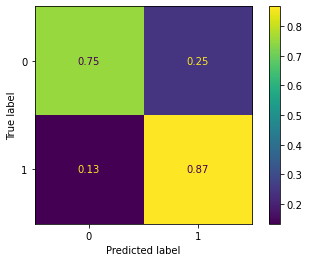

In [8]:
y_pr_log = log_mod.predict(X_test)
cm = confusion_matrix(y_test,y_pr_log,normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [9]:
log_mod.score(X_test,y_test)

0.8094561688311688

Nice, 81% mean accuracy is not too bad for this completely balanced dataset. Also, the scores on the test and train datasets is very close, implying that the model did not overfit (possibly because the data is fairly simple and homogenous over thousands of samples).

### What effect does "step" variable have in terms of model predictions?
What would be the effect of removing step? In the "real-world", the time of day would likely play an important role in fraud prediction. Is that also the case for this dataset? During our EDA, we did see that fraud was uniformly occurring (except very early and near the end, where the fraud decreased). However, the legitimate transactions had strong heterogeneity in their occurrence. Let's remove step to see how it affects the score for the model above.

In [15]:
X_train_no_step = X_train.drop(columns='step')
log_mod_no_step = LogisticRegression(random_state=42)
log_mod_no_step.fit(X_train_no_step,y_train)
log_mod_no_step.score(X_train_no_step,y_train)

0.7682205600974082

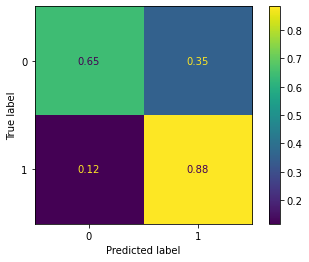

In [16]:
X_test_no_step = X_test.drop(columns='step')
y_pr_log_no_step = log_mod_no_step.predict(X_test_no_step)
cm = confusion_matrix(y_test,y_pr_log_no_step,normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [17]:
log_mod_no_step.score(X_test_no_step,y_test)

0.7635957792207793

It appears that step does improve the model predictions by about 5% mean accuracy. From the confusion matrix, we see that the area the model benefited from most with step is the avoiding false positives (upper-right quadrant of confusion matrix) and missing true negatives (upper-left quadrant). 
This makes sense, because the step provides data on where the legitimate transactions are concentrated. Without this information, the model overpredicts fraud.

## Time-Based Model Accuracy

Typically, k-fold cross validation is the way that we access the performance of machine learning model and guard against overfitting. The process of randomly partitioning and fitting the model on n-1 folds and testing its performance on the remaining fold works well for predictions that can be assumed to be independent of time. However, when there is a temporal component to a problem where statistics can change with time, a time-based cross validation is usually a better assessment of the model’s performance. This approach allows us to capture how well the model does over different time periods. With time-based cross validation, the training data always comes from a time before the testing data, where this “sliding window” method trains and tests data at successive, equally spaced periods of time.

As mentioned, the time-based cross validation approach is only necessary if the model’s performance depends strongly on the time interval. Let’s see if this is the case with our data. 

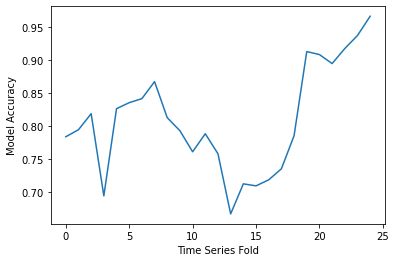

In [252]:
#calculate accuracy of logistic regression classifier on time-step sorted data over n intervals
n=25
scores=[]
n_len = len(X_all)
n_len_1 = int(n_len/n)
start = 0
end = n_len_1
for i in range(0,n):
    #print(start,end)
    X_fold = X_all[start:end]
    y_fold = y_all[start:end]
    score = n_log_mod.score(X_fold,y_fold)
    scores.append(score)
    start = start + n_len_1 +1
    end = end + n_len_1 +1
plt.plot(scores)
plt.xlabel('Time Series Fold')
plt.ylabel('Model Accuracy')
plt.show()

In [256]:
np.max(scores)

0.9668769716088328

We see that the model does particularly well in the later time steps and poorly during the beginning and middle. Why is this? From the confusion matrix, we know that the logistic model does very well with classifying fraudulent transactions but less well when it comes to predicting legitimate transactions. Perhaps the variation in the model's peformance comes from the relative ratio of legitimate transactions in the test data.

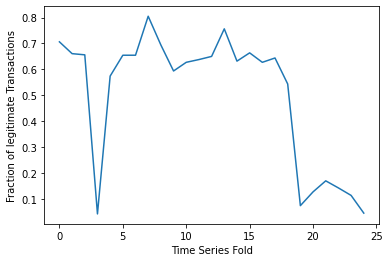

In [246]:
n=25
fracs_legit=[]
n_len = len(X_all)
n_len_1 = int(n_len/n)
start = 0
end = n_len_1
for i in range(0,n):
    #print(start,end)
    y_fold = y_all[start:end]
    frac_legit = len(y_fold[y_fold == 0]) / len(y_fold)
    fracs_legit.append(frac_legit)
    start = start + n_len_1 +1
    end = end + n_len_1 +1
plt.plot(fracs_legit)
plt.xlabel('Time Series Fold')
plt.ylabel('Fraction of legitimate Transactions')
plt.show()

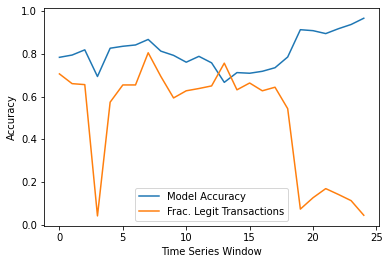

In [257]:
plt.plot(scores,label='Model Accuracy')
plt.plot(fracs_legit,label='Frac. Legit Transactions')
plt.ylabel('Accuracy')
plt.xlabel('Time Series Window')
plt.legend()
plt.show()

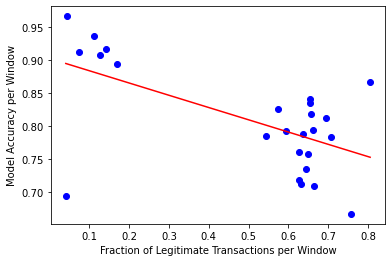

In [276]:
#np.polyfit(fracs_legit,scores,deg=1)
from scipy.stats import linregress
from scipy import stats
x=fracs_legit
y=scores
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,10)
y1=gradient*x1+intercept
plt.plot(x,y,'ob')
plt.plot(x1,y1,'-r')
plt.xlabel('Fraction of Legitimate Transactions per Window')
plt.ylabel('Model Accuracy per Window')
plt.show()

In [277]:
gradient, intercept, r_value, p_value, std_err

(-0.18636951799813445,
 0.902783356808889,
 -0.5920929647809219,
 0.0018201301174300601,
 0.05289149864613866)

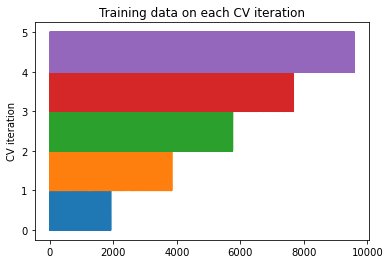

In [13]:
# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=5)
# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X_train, y_train)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y_train[tr])
ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

In [74]:
X_all = pd.read_csv('../data/Data_Features.csv')
y_all = pd.read_csv('../data/Data_Labels.csv')

In [75]:
all_vals = X_all.merge(y_all,left_index=True,right_index=True).sort_values(by='step')
X_all = all_vals.drop(columns=['isFraud'])
y_all = all_vals['isFraud']

In [96]:
tscv = TimeSeriesSplit(n_splits=10)
test_scores = []
train_scores = []
train_indices = []
test_indices = []
for train_index, test_index in tscv.split(X_all):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_indices.append(train_index)
    test_indices.append(test_index)
    X_train_ts, X_test_ts = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train_ts, y_test_ts = y_all.iloc[train_index], y_all.iloc[test_index]
    #fit model
    log_mod.fit(X_train_ts,y_train_ts)
    train_scores.append(log_mod.score(X_train_ts,y_train_ts))
    test_scores.append(log_mod.score(X_test_ts,y_test_ts))
    

In [97]:
train_indices

[array([   0,    1,    2, ..., 1493, 1494, 1495]),
 array([   0,    1,    2, ..., 2986, 2987, 2988]),
 array([   0,    1,    2, ..., 4479, 4480, 4481]),
 array([   0,    1,    2, ..., 5972, 5973, 5974]),
 array([   0,    1,    2, ..., 7465, 7466, 7467]),
 array([   0,    1,    2, ..., 8958, 8959, 8960]),
 array([    0,     1,     2, ..., 10451, 10452, 10453]),
 array([    0,     1,     2, ..., 11944, 11945, 11946]),
 array([    0,     1,     2, ..., 13437, 13438, 13439]),
 array([    0,     1,     2, ..., 14930, 14931, 14932])]

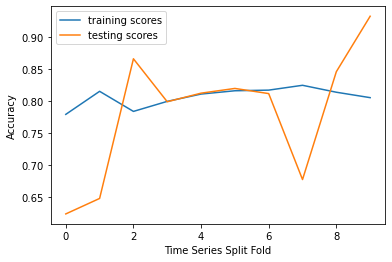

In [95]:
plt.plot(train_scores,label='training scores')
plt.plot(test_scores,label='testing scores')
plt.xlabel('Time Series Split Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [170]:
def accuracy_empirical_distributions(n=1000):
    '''
    Bootstrap determination of logistic model accuracy for each time split
    
    Takes number of runs as input
    
    Training with the LogisticRegression(C=100,max_iter=1000,random_state=42) model since
    performance is almost as good as LogisticRegression(C=0.1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
    random_state=42, solver='saga') model, but training is much quicker!
    '''
    accuracy_array_list = []
    for cv in range(0,6):
        X_train_ts, X_test_ts = X_all.iloc[train_indices[cv]], X_all.iloc[test_indices[cv]]
        y_train_ts, y_test_ts = y_all.iloc[train_indices[cv]], y_all.iloc[test_indices[cv]]
        accuracy_array = []
        for i in range(0,n):
            bs_sample = np.random.choice(X_train_ts.index, size=len(X_train_ts))
            X_bs = X_train_ts.loc[bs_sample]
            y_bs = y_train_ts.loc[bs_sample]
            n_log_mod = LogisticRegression(C=100,max_iter=1000,random_state=42)
            n_log_mod.fit(X_bs,y_bs)
            accuracy_array.append(n_log_mod.score(X_test_ts,y_test_ts))
        accuracy_array_list.append(accuracy_array)
    return(accuracy_array_list)

In [171]:
accuracy_array_return = accuracy_empirical_distributions()

In [175]:
accuracy_means = [np.mean(x) for x in accuracy_array_return]
accuracy_ci = [2*np.std(x) for x in accuracy_array_return]

Text(0.5, 0, 'Time Series Split Fold')

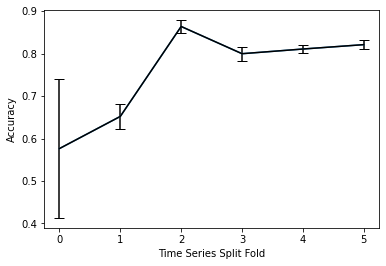

In [191]:
plt.plot(accuracy_means)
plt.errorbar(x=range(0,len(accuracy_ci)),y=accuracy_means,yerr=accuracy_ci,color='black',ecolor='black',capsize=5)
plt.ylabel('Accuracy')
plt.xlabel('Time Series Split Fold')

### ROC Curve
Keeping step in the model, let's plot the ROC curve.

In [19]:
#get false positive and true postive rates with predicted probabilities from log_mod
fpr, tpr, thresholds = roc_curve(y_test,log_mod.predict_proba(X_test)[:,1])

In [20]:
area_under_curve = round(auc(fpr,tpr),3)
area_under_curve

0.893

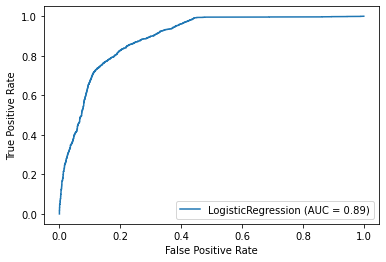

In [72]:
plot_roc_curve(log_mod, X_test, y_test,response_method='predict_proba')

An AUC of 0.89 is great! Of course, we also want to use the amount of money lost assessing the model's success. If the model is not able to detect fraud with high dollar amounts, or is equally likely to misclassify high and low dollar fraud, then this would not be desirable. 

### Grid search with cross validation for hyperparameter tuning

Allow for l1 or l2 penalty with liblinear solver and range of regularization strengths.

In [39]:
Cs = [0.001, 0.1, 1, 10, 100]
pnlty = ['l2','l1']
slvr = ['liblinear']
param_grid = {'penalty':pnlty,'C': Cs, 'solver' : slvr}

log_mod_gs = GridSearchCV(log_mod,param_grid,cv=5)

#fit data
log_mod_gs.fit(X_test,y_test)
log_mod_gs.best_score_

0.8088452548882323

In [40]:
log_mod_gs.best_estimator_

LogisticRegression(C=0.1, random_state=42, solver='liblinear')

Keep default penalty and solver with more iterations added and range of regularization strengths.

In [138]:
Cs = [0.001, 0.1, 1, 10, 100]
pnlty = ['l2']
slvr = ['lbfgs']
mx_iter = [1000]
param_grid = {'penalty':pnlty,'C': Cs, 'solver' : slvr,'max_iter':mx_iter}

log_mod_gs = GridSearchCV(log_mod,param_grid,cv=5)

#fit data
log_mod_gs.fit(X_test,y_test)
log_mod_gs.best_score_

0.8092513462587906

In [139]:
log_mod_gs.best_estimator_

LogisticRegression(C=100, max_iter=1000, random_state=42)

In [141]:
log_mod_best_2 = LogisticRegression(C=100, max_iter=1000, random_state=42)
log_mod_best_2.fit(X_train,y_train)
log_mod_best_2.coef_

array([[ 0.00325436, -1.28171206,  0.19225175, -2.6670484 ,  1.57758809,
         0.36963756]])

Change to elastic net penalty and also vary l1 ratios with saga solver.

In [25]:
Cs = [0.001, 0.1, 1, 10, 100]
l1 = [0,0.1,0.5,1]
pnlty = ['elasticnet']
slvr = ['saga']
mx_iter = [10000]
param_grid = {'penalty':pnlty,'C': Cs, 'solver' : slvr,'max_iter':mx_iter,'l1_ratio':l1}

log_mod_gs = GridSearchCV(log_mod,param_grid,cv=5)

#fit data
log_mod_gs.fit(X_test,y_test)
log_mod_gs.best_score_

0.8116862470526456

In [26]:
log_mod_gs.best_estimator_

LogisticRegression(C=0.1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   random_state=42, solver='saga')

In [27]:
log_mod_gs.score(X_train,y_train), log_mod_gs.score(X_test,y_test)

(0.8113584971299357, 0.8120941558441559)

From the three grid searches above, it appears that no significant gains are to be had by hyperparameter tuning for this logistic model. The best mean accuracy is still about 81%. Both train and test scores are very similar, suggesting no over-fitting.

In [33]:
log_mod_best = LogisticRegression(C=0.1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   random_state=42, solver='saga')

log_mod_best.fit(X_train,y_train)

array([[ 0.00300864, -1.11747313,  0.2312698 , -2.2142325 ,  1.32802913,
         0.34412942]])

In [41]:
print(log_mod_best.coef_)

[[ 0.00300864 -1.11747313  0.2312698  -2.2142325   1.32802913  0.34412942]]


In [127]:
def coefficient_empirical_distributions(n=1000):
    '''
    Bootstrap determination of logistic model coefficents
    
    Takes number of runs as input
    
    Training with the LogisticRegression(C=100,max_iter=1000,random_state=42) model since
    performance is almost as good as LogisticRegression(C=0.1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
    random_state=42, solver='saga') model, but training is much quicker!
    '''
    coef_array = []
    for i in range(0,n):
        bs_sample = np.random.choice(X_train.index, size=len(X_train))
        X_bs = X_train.iloc[bs_sample]
        y_bs = y_train.iloc[bs_sample]
        n_log_mod = LogisticRegression(C=100,max_iter=1000,random_state=42)
        n_log_mod.fit(X_bs,y_bs)
        coef_array.extend(n_log_mod.coef_.tolist())
    return(coef_array)

In [129]:
coefs = coefficient_empirical_distributions()

In [142]:
coef_df = pd.DataFrame(coefs,columns=['step','type_CASH_OUT','type_TRANSFER','drain_Orig_account_No',
                                      'drain_Orig_account_Yes','amount_scaled'])
coef_df.head()

,step,type_CASH_OUT,type_TRANSFER,drain_Orig_account_No,drain_Orig_account_Yes,amount_scaled
0,0.003495,-1.270509,0.123990,-2.689833,1.543314,0.353092
1,0.003302,-1.375481,0.286264,-2.712139,1.622921,0.377500
2,0.003312,-1.252039,0.149144,-2.697352,1.594457,0.373358
3,0.003457,-1.302556,0.161630,-2.726785,1.585860,0.386442
4,0.003133,-1.302024,0.230291,-2.672281,1.600549,0.334250


array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'type_CASH_OUT'}>],
       [<AxesSubplot:title={'center':'type_TRANSFER'}>,
        <AxesSubplot:title={'center':'drain_Orig_account_No'}>],
       [<AxesSubplot:title={'center':'drain_Orig_account_Yes'}>,
        <AxesSubplot:title={'center':'amount_scaled'}>]], dtype=object)

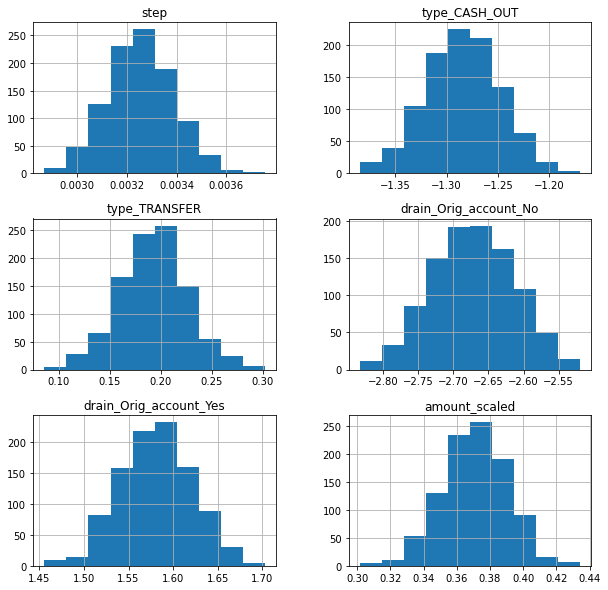

In [149]:
#plot of estimated coefficient values from bootstrapped samples fitted to logistic regression model
coef_df.hist(figsize=(10,10))

In [153]:
#get 1st and 99th percentiles for distribution of coefficients
coef_df.quantile([0.01,0.99])

,step,type_CASH_OUT,type_TRANSFER,drain_Orig_account_No,drain_Orig_account_Yes,amount_scaled
0.01,0.002959,-1.373842,0.118406,-2.805243,1.491057,0.326832
0.99,0.003568,-1.201032,0.272883,-2.546273,1.672308,0.417037


Based on the coefficients of the logistic model, the step, type_TRANSFER, drain_Orig_account_Yes, and amount scaled are correlated with a fraudulent transaction, whereas type_CASH_OUT and drain_Orig_account_No are negatively correlated with fraud.

From a simulation of 1000 bootstrapped samples used to fit the same logistic regression model, inspection of the histogram plots of the coefficients and the table of 1st to 99th percentile ranges of each coefficent distribution in the table above indicate that they are all statistically significant at p = ~0.

# Random Forest Classifer

The random forest ensemble classifier is one of the most versatile and robust out-of-the-box classifiers in existence today. They are typically easy to tune and hard to overfit relative to gradient boosting, and the method is very easy to parallelize. Let's try it out on our dataset! 

In [14]:
#random forest with default parameters
rf_mod = RandomForestClassifier(random_state=42,n_jobs=-1)

In [ ]:
rf_mod.fit(X_train,y_train)
y_pred_rf = rf_mod.predict(X_test)

In [248]:
#training error without cross-validation
rf_mod.score(X_train,y_train)

1.0

The train accuracy is 100%! What about if we use cross-validation?

In [198]:
#training data error with cv
cv_rf_tr = cross_val_score(rf_mod, X_train, y_train, cv=5)
print(cv_rf_tr)
print(cv_rf_tr.mean())

[0.89478261 0.88       0.88652174 0.88081775 0.88864724]
0.8861538665204153


So, with cv the accuracy on the training set is around 89%.  The cross-validated scores give us a much better idea of how the model will perform in "real life". However, what's really important is the score on the test data.

In [189]:
#testing data error with cv
cv_rf_tst = cross_val_score(rf_mod, X_test, y_test, cv=5)
print(cv_rf_tst)
print(cv_rf_tst.mean())

[0.87018256 0.87221095 0.86916836 0.89238579 0.9035533 ]
0.8815001904840354


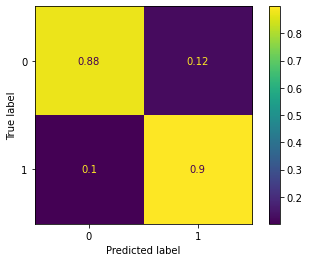

In [199]:
cm = confusion_matrix(y_test, y_pred_rf,normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [200]:
fpr, tpr, thresholds = roc_curve(y_test,rf_mod.predict_proba(X_test)[:,1])
area_under_curve = round(auc(fpr,tpr),3)
area_under_curve

0.957

Even without any hyperparameter tuning, the random forest model outperforms even the best logistic regression model so far! Both true positives and true negatives predictions are around 90% accurate, and overall mean accuracy is about 88% (compared to about 81% for the logistic regression model). The area under the ROC curve is also close to 0.96 for the random forest, compared to the 0.89 for the logistic model. Clearly, random forest is a better model for the classification of fraudulent transactions.

#### Log Loss
Let's try log loss as another evaluation metric

In [158]:
#random forest log loss
rf_log_loss = log_loss(y_test, rf_mod.predict_proba(X_test)[:,1])
rf_log_loss

0.40529049945924056

In [117]:
#logistic regression log loss
log_log_loss = log_loss(y_test,log_mod.predict_proba(X_test)[:,1])
log_log_loss

0.3958530149181658

Interstingly, the logarithmic model has a slightly lower log loss compared to the random forest. This implies that the random forest model's was more certain of its incorrect classifications as compared to the logistic model. 

#### Matthews correlation coefficient

In [120]:
#logistic regression
matthews_corrcoef(y_test, y_pr_log)

0.5438029449773948

In [159]:
#random forest
matthews_corrcoef(y_test, y_pred_rf)

0.7746053697138746

The MCC takes into account all quadrants of the confusion matrix (true positive, false positive, true negative, and false negative). The metric is independent of the positive/negative label (i.e., they can be swapped without affecting the MCC), and is hence better than the F1 score for binary classification.

Here, we notice that the MCC is significantly better for the random forest model compared to logistic regression.

### Grid Search with Random Forest

In [249]:
n_est = [10,100,1000]
crtrn = ['gini','entropy']
mxdpth = [None,2,5,10,20]
param_grid = {'n_estimators':n_est,'criterion': crtrn, 'max_depth' : mxdpth}

rf_mod_gs = GridSearchCV(rf_mod,param_grid,cv=5)

#fit data
rf_mod_gs.fit(X_train,y_train)
rf_mod_gs.best_score_

0.8896321273899804

In [251]:
rf_mod_gs.score(X_test,y_test)

0.890625

The grid search very slightly improved the mean classification accuracy of the random forest model by about 1 percent when varying the number of estimators, the purity gain criterion, and the maximum depth of the trees relative to the default values.

The best parameters are listed below:

In [250]:
rf_mod_gs.best_params_

{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}

## Effect of varying min samples to split node on random forest model accuracy

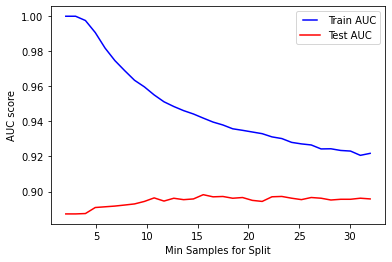

In [191]:
#code below taken from https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
min_splits = np.linspace(2, 32, 32, endpoint=True)
train_results = []
test_results = []
for min_split in min_splits:
   rf = RandomForestClassifier(min_samples_split=int(min_split), random_state=42, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Min Samples for Split')
plt.show()

At smaller minimum samples required for a split, the random forest model seemed to be overfitting. This makes sense, since if we increase this number then there is a reduced chance for the forest to fit to noise in the data. 
Recall, with min samples required for splitting set at 2, we at 100% accuracy with the training data, but under 89% with test data. 

It looks like around min samples for split of 15, we maximize the test AUC.

In [16]:
#random forest grid search including min_samples_split
n_est = [10,100,1000]
crtrn = ['gini','entropy']
mxdpth = [None,2,5,10,20]
min_ss = [5,10,15,20]
param_grid = {'n_estimators':n_est,'criterion': crtrn, 'max_depth' : mxdpth, 'min_samples_split' : min_ss}

rf_mod_gs = GridSearchCV(rf_mod,param_grid,cv=5)

#fit data
rf_mod_gs.fit(X_train,y_train)
rf_mod_gs.best_score_

0.8946773455377575

In [17]:
rf_mod_gs.score(X_train,y_train), rf_mod_gs.score(X_test,y_test)

(0.9551226300226127, 0.8963068181818182)

In [18]:
rf_mod_gs.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 10,
 'n_estimators': 100}

In [248]:
#random forest with default parameters
rf_mod2 = RandomForestClassifier(random_state=42,n_jobs=-1, criterion='gini',max_depth=None,min_samples_split=10,n_estimators=100)

In [21]:
#training data error
cv_rf_tr = cross_val_score(rf_mod2, X_train, y_train, cv=5)
print(cv_rf_tr)
print(cv_rf_tr.mean())

[0.90043478 0.89130435 0.89217391 0.89430187 0.89517181]
0.8946773455377575


In [22]:
#training data error
cv_rf_tst = cross_val_score(rf_mod2, X_test, y_test, cv=5)
print(cv_rf_tst)
print(cv_rf_tst.mean())

[0.88336714 0.88336714 0.87221095 0.89441624 0.90050761]
0.8867738182267481


In [25]:
rf_mod2.fit(X_train,y_train)
y_pred_rf = rf_mod2.predict(X_test)

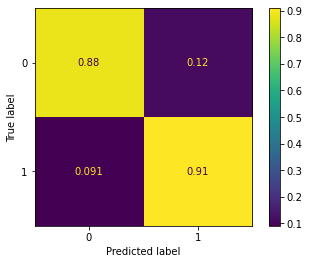

In [26]:
cm = confusion_matrix(y_test, y_pred_rf,normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

The tuning of the hyperparameter for min number of samples required for a split did imporve the random forest model, albeit by only a percent or so. But, with fraud, every bit helps!

## Feature Importance

The feature importance (also known as Gini importance) and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.

6


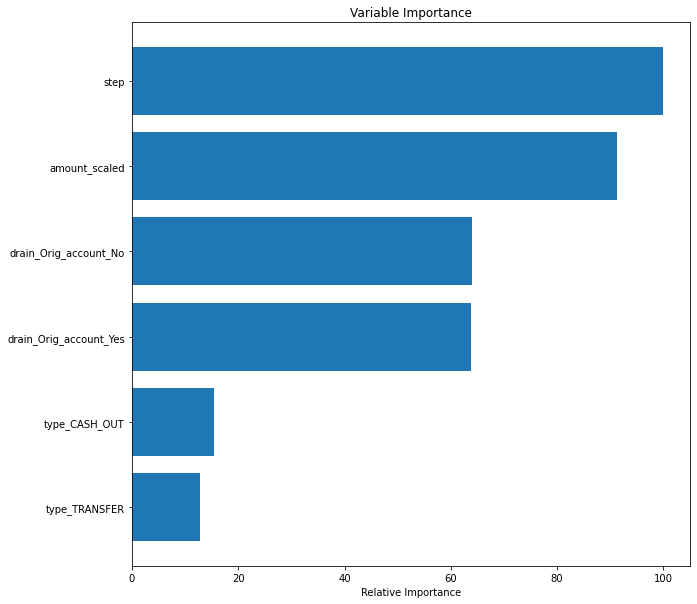

In [28]:
#code below adapted from Springboard Random Forest Case Study Notebook
feature_importance = rf_mod2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:6]
sorted_idx = np.argsort(feature_importance)[:6]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

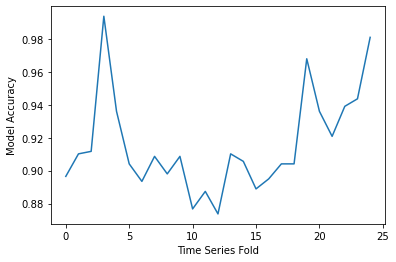

In [250]:
#calculate accuracy of logistic regression classifier on time-step sorted data over n intervals
n=25
scores=[]
n_len = len(X_all)
n_len_1 = int(n_len/n)
start = 0
end = n_len_1
rf_mod2.fit(X_train,y_train)
for i in range(0,n):
    #print(start,end)
    X_fold = X_all[start:end]
    y_fold = y_all[start:end]
    score = rf_mod2.score(X_fold,y_fold)
    scores.append(score)
    start = start + n_len_1 +1
    end = end + n_len_1 +1
plt.plot(scores)
plt.xlabel('Time Series Fold')
plt.ylabel('Model Accuracy')
plt.show()

From our calculation of the feature (or Gini) importance, we see that the variable step is the most important predictor for fraud, followed by whether the account of the originator is emptied or not. Finally, the transaction type is the least important group of features. 

# Support Vector Machines
 
Support vector machine (SVM) classifiers can be very accurate. They do need to be more carefuly tuned than RF models and are more senstive to outliers. Let's try a SVM model on our mobile transactions data.

Another possible issue with SVM is that the time to fit the model varies as $O(n^2)$, which can make it impractical for larger datasets.

In [7]:
#starting with default parameters to get baseline performance
svm_mod = SVC(random_state=42)
cv_svm_tr = cross_val_score(svm_mod, X_train, y_train, cv=5)

In [228]:
print(cv_svm_tr)
cv_svm_tr.mean()

[0.69391304 0.7026087  0.70652174 0.6876903  0.68377555]


0.6949018665960626

In [ ]:
cm = confusion_matrix(y_test, cv_svm_tr.p,normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [230]:
svm_mod.fit(X_train,y_train)
svm_mod.score(X_test,y_test)

0.697849025974026

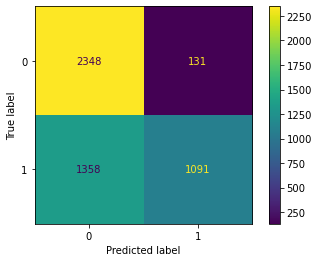

In [233]:
y_pred_svm = svm_mod.predict(X_test)
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [236]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.63      0.95      0.76      2479
           1       0.89      0.45      0.59      2449

    accuracy                           0.70      4928
   macro avg       0.76      0.70      0.68      4928
weighted avg       0.76      0.70      0.68      4928



Without any hyperparameter tuning, the SVM model does not do very well relative to either logistic regression or RF, achieving a mean accuracy of only about 69%. From the confusion matrix above, the biggest problem with the SVM model is that it incorrectly predicts many fraudulent transactions as legitimate (poor recall). This is very bad in our case, and suggests that the hyperparameters require tuning.

## Grid Searach for SVM

In [29]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

svm_mod_gs = GridSearchCV(svm_mod,param_grid,cv=5)

#fit data
svm_mod_gs.fit(X_train,y_train)
svm_mod_gs.best_score_

0.8960687633564689

In [31]:
svm_mod_gs.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [32]:
svm_mod_gs.score(X_train,y_train), svm_mod_gs.score(X_test,y_test)

(0.9132022960514872, 0.8952922077922078)

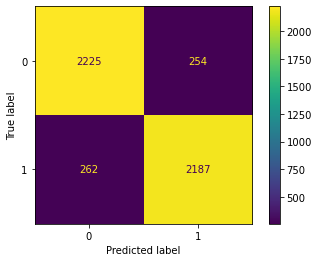

In [30]:
y_pred_svm_gs = svm_mod_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred_svm_gs)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

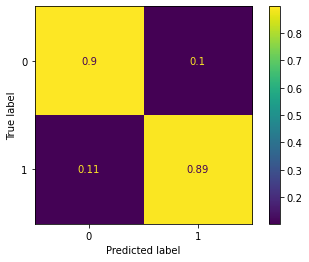

In [12]:
y_pred_svm_gs = svm_mod_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred_svm_gs,normalize='true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [239]:
print(classification_report(y_test, y_pred_svm_gs))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2479
           1       0.90      0.89      0.89      2449

    accuracy                           0.90      4928
   macro avg       0.90      0.90      0.90      4928
weighted avg       0.90      0.90      0.90      4928



In [66]:
svm_mod_prob = SVC(C=1000,gamma=0.01,kernel='rbf',random_state=42,probability=True)

#fit data
svm_mod_prob.fit(X_train,y_train)

SVC(C=1000, gamma=0.01, probability=True, random_state=42)

With a little hyperparameter tuning, the SVM classifier went from being by far the worst model to the best, yeilding 90% mean accuracy!

# Final comparison of Logistic Regression, Random Forest, and Support Vector Machines Classifiers

We have looked at many differnt comparison evaluation metrics for the three models discussed above. Fraud is very costly to customers and the money transfer company. While false positives can be annoying to the customer, they are far better than false negatives where entire accounts can be wiped out. Ultimately, we want to choose a metric that focuses on minimizing the false negatives, or equivalently, maximizing recall. 

Let's look at our classification reports again for the best logistic and random forest models, again. 

## Logistic Regression

In [242]:
print(classification_report(y_test, log_mod_gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      2479
           1       0.78      0.87      0.82      2449

    accuracy                           0.81      4928
   macro avg       0.82      0.81      0.81      4928
weighted avg       0.82      0.81      0.81      4928



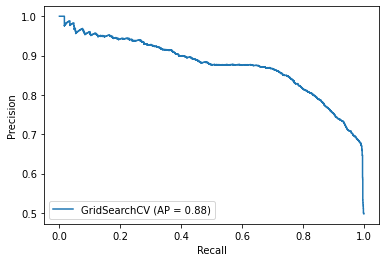

In [254]:
plot_precision_recall_curve(log_mod_gs,X_test,y_test)

## Random Forest

In [252]:
print(classification_report(y_test, rf_mod_gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2479
           1       0.89      0.90      0.89      2449

    accuracy                           0.89      4928
   macro avg       0.89      0.89      0.89      4928
weighted avg       0.89      0.89      0.89      4928



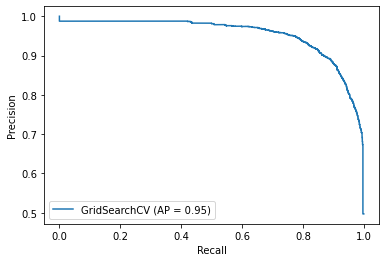

In [255]:
plot_precision_recall_curve(rf_mod_gs,X_test,y_test)

## Support Vector Machine

In [244]:
print(classification_report(y_test, y_pred_svm_gs))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2479
           1       0.90      0.89      0.89      2449

    accuracy                           0.90      4928
   macro avg       0.90      0.90      0.90      4928
weighted avg       0.90      0.90      0.90      4928



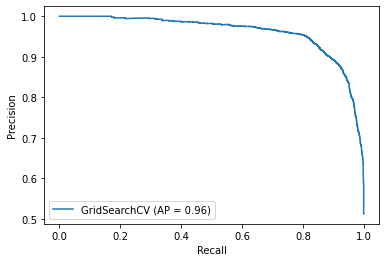

In [256]:
plot_precision_recall_curve(svm_mod_gs,X_test,y_test)

In [67]:
p1,r1,_ = precision_recall_curve(y_test,log_mod_gs.predict_proba(X_test)[:,1])
p2,r2,_ =precision_recall_curve(y_test,rf_mod_gs.predict_proba(X_test)[:,1])
p3,r3,_ =precision_recall_curve(y_test,svm_mod_prob.predict_proba(X_test)[:,1])

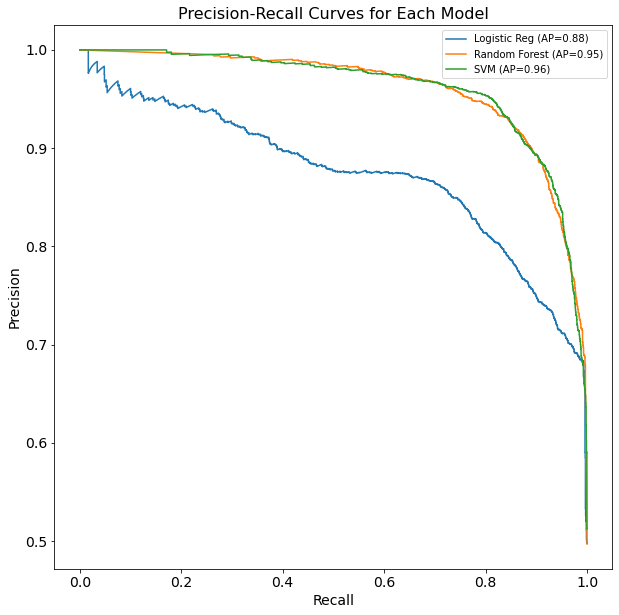

In [82]:
plt.figure(figsize=(10,10))
plt.plot(r1,p1,label='Logistic Reg (AP=0.88)')
plt.plot(r2,p2,label='Random Forest (AP=0.95)')
plt.plot(r3,p3,label='SVM (AP=0.96)')
plt.xlabel("Recall",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Precision",fontsize=14)
plt.title("Precision-Recall Curves for Each Model",fontsize=16)
plt.legend()
plt.show()

# Conclusions

The best performing model in terms of overall accuracy was the SVM classifier, but RF is very close to the same performance. Also, RF is much faster to fit (parallelizable) and does not require extensive hyperparameter tuning to get a reasonable result, whereas SVM took a long time to fit and where hyperparameter tuning was essential for model performance.
SVM beat RF in terms of F1-score and average precision, but again, only slightly. In conclusion, SVM is the best classifier among the group, but whether it would be a good as real-time fraud detection model that may need to continously learn off of new data is another question. 

Overall, the random forest model may be better than SVM since no lengthly hyperparameter tuning needs to be done, and is much faster to train and more robust to outliers, overall. Furthermore, it scales better with more observations compared to SVM.

Logistic regression, while providing reasonable performance, was clearly the worst model in the group for this problem.

Finally, from the RF classifier, we saw that step is the most important feature in terms of Gini importance, followed by whether the account of the originator was emptied or not and then the transaction type coming in last.